In [1]:
import sys
sys.path.insert(0, '../backend')
sys.path.insert(0, '../../data')

In [2]:
import numpy as np
import time
import pandas as pd
import seaborn
import matplotlib.pyplot as plt

import pybnb

from branch_and_bound_warped_pvar import BnBWarping
from transformers import *

warped p-var: 28.85
wall time: 42.09 secs 
 



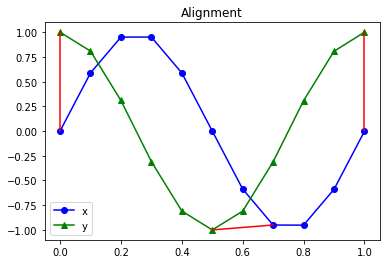

In [6]:
idx = np.linspace(0, 6.28, 11)
x = np.sin(idx)
y = np.cos(idx)

x = AddTime().fit_transform([x])[0]
y = AddTime().fit_transform([y])[0]

problem = BnBWarping(x, y, depth=2, norm='l1', p=2., plot_2d=True, boundary_condition=3)

solver = pybnb.Solver()

results = solver.solve(problem, log=None, queue_strategy='depth')
#results = solver.solve(problem, log=None, queue_strategy=('depth', 'random'))

print('warped p-var: {:.2f}'.format(results.objective))
print('wall time: {:.2f} secs \n \n'.format(results.wall_time))

best_warp = results.best_node.state
_, optimal_partition = problem.distance(results.best_node.state, optim_partition=True)
problem.plot_alignment([best_warp[k] for k in optimal_partition])
plt.show()

In [7]:
print('total # of soft bound calls (always):', problem.count_soft_bound_calls)
print('total # of times soft bound is enough:', problem.count_soft_bound_sufficiency)
print('total # of tight bound calls:', problem.count_tight_bound_calls)
print('total # of times tight bound is enough:', problem.count_tight_bound_sufficiency)
print('all the rest: ', problem.all_the_rest)

total # of soft bound calls (always): 8577
total # of times soft bound is enough: 1461
total # of tight bound calls: 7116
total # of times tight bound is enough: 3577
all the rest:  3539


# Hyperparameter tuning

In [3]:
final_times = {}
final_nodes = {}
final_wpv = {}

lengths = range(6, 13)
boundary_conditions = range(2, 6)
   
for N in lengths:
    
    times = {}
    nodes = {}
    wpv = {}

    idx = np.linspace(0, 6.28, N)
    x = np.sin(idx)
    y = np.cos(idx)

    x = AddTime().fit_transform([x])[0]
    y = AddTime().fit_transform([y])[0]
    
    for bc in boundary_conditions:

        problem = BnBWarping(x, y, depth=2, norm='l1', p=1.5, boundary_condition=bc)
        solver = pybnb.Solver()
        results = solver.solve(problem, log=None, queue_strategy='depth')

        times[f'boundary_condition: {bc}'] = results.wall_time
        nodes[f'boundary_condition: {bc}'] = results.nodes
        wpv[f'boundary_condition: {bc}'] = results.objective
    
    problem = BnBWarping(x, y, depth=2, norm='l1', p=1.5, use_dp=False)
    solver = pybnb.Solver()
    results = solver.solve(problem, log=None, queue_strategy='depth')
    
    times['without DP'] = results.wall_time
    nodes['without DP'] = results.nodes
    wpv['without DP'] = results.objective
    
    final_times[f'length: {N}'] = times
    final_nodes[f'length: {N}'] = nodes
    final_wpv[f'length: {N}'] = wpv

In [4]:
df_times = pd.DataFrame.from_dict(final_times)
df_nodes = pd.DataFrame.from_dict(final_nodes)
df_wpv = pd.DataFrame.from_dict(final_wpv)

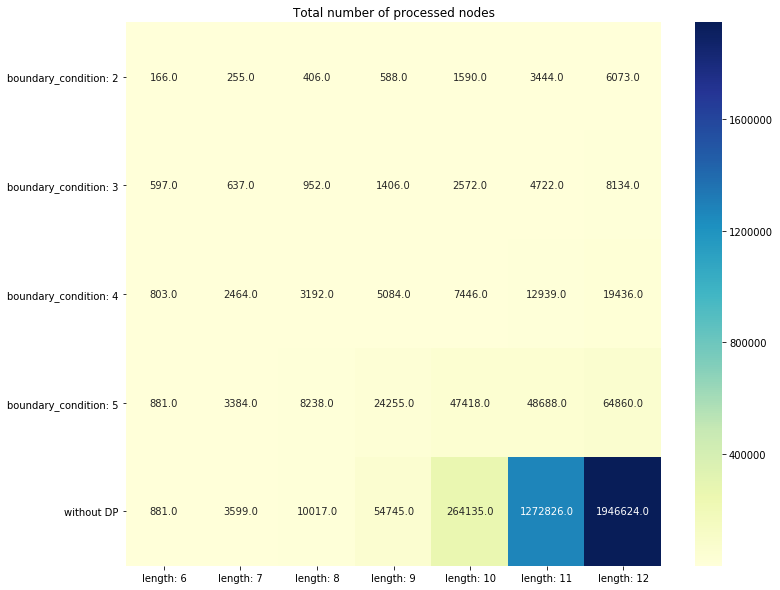

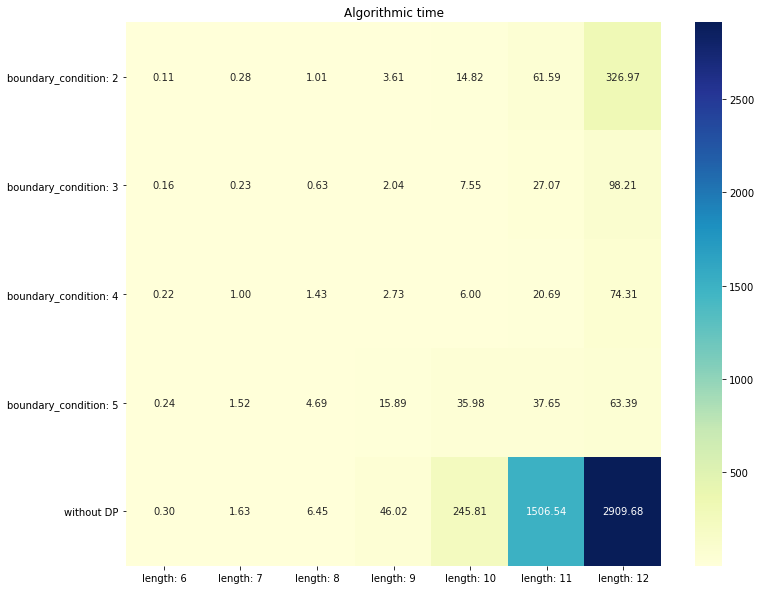

In [5]:
plt.figure(figsize=(12, 10))
seaborn.heatmap(df_nodes, annot=True, cmap="YlGnBu", fmt='.1f')
plt.title('Total number of processed nodes')
plt.show()

plt.figure(figsize=(12, 10))
seaborn.heatmap(df_times, annot=True, cmap="YlGnBu", fmt='.2f')
plt.title('Algorithmic time')
plt.show()